In [2]:
import pickle
from model_and_circuit import *
from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


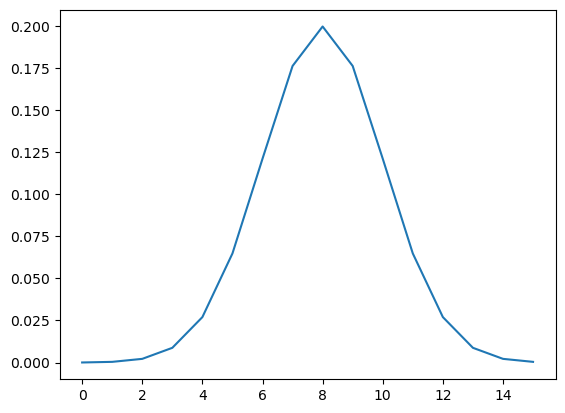

In [3]:
with open("/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/4qubit_target_distribution.pkl", "rb") as f:
    target_distribution = pickle.load(f)
plt.plot(target_distribution)

In [4]:
# qml.draw_mpl(circuit,device='default')(initial_params)
# plt.show() 

In [5]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        return self.mmd(px,self.py), px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = jnp.asarray(qcbm_probs, dtype=jnp.float64)
    
    kl_div = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs) - jnp.log(target_distribution)))
    
    return params, opt_state, loss_val, kl_div


In [6]:
# #Load the Checkpoint

# with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/model/data_ancilla/model_checkpoint_0.01_13135.pkl', "rb") as file:
#     checkpoint = pickle.load(file)

# start_epoch = checkpoint["final_epoch"] + 1
# weights = checkpoint["parameters"]
# loss_values = checkpoint["history"]
# kl_values = checkpoint["divs"]

# print(f"Resuming training from epoch {start_epoch}...")

In [7]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# lr = 0.025
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0 
# i = start_epoch

# while kl_div > 10^-3:
while i < 1001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.0024536973796784878 KL_div:0.10333506762981415 current_lr:0.10000000149011612 Time taken per iteration: 0.03067755699157715
Step: 20 Loss: 0.0007811266696080565 KL_div:0.04019840061664581 current_lr:0.10000000149011612 Time taken per iteration: 0.015007257461547852
Step: 30 Loss: 0.00020866344857495278 KL_div:0.015115797519683838 current_lr:0.10000000149011612 Time taken per iteration: 0.010535240173339844
Step: 40 Loss: 3.563290374586359e-05 KL_div:0.0040932921692729 current_lr:0.10000000149011612 Time taken per iteration: 0.014410734176635742
Step: 50 Loss: 2.0150851923972368e-05 KL_div:0.002175077795982361 current_lr:0.10000000149011612 Time taken per iteration: 0.011169672012329102
Step: 60 Loss: 9.654530003899708e-06 KL_div:0.0016271250788122416 current_lr:0.10000000149011612 Time taken per iteration: 0.012920618057250977
Step: 70 Loss: 3.2392995308327954e-06 KL_div:0.00163239985704422 current_lr:0.10000000149011612 Time taken per iteration: 0.010274648666381836
S

In [8]:
import pickle

#Save Checkpoint
checkpoint = {"final_epoch":i,
              "history":history,
              "divs":divs,
              "parameters":parameters}

# with open(f'anticat_model_distribution_copy.pkl','wb') as file:
with open(f'4qubit_cat_model_checkpoint.pkl','wb') as file:
    pickle.dump(checkpoint,file)
    
print("Model saved successfully")

Model saved successfully


In [9]:
# fig, axs = plt.subplots(1,2,figsize=(15,8))
# axs[0].plot(kl_values)
# axs[0].title.set_text('KL Divergence')

# axs[1].plot(loss_values)
# axs[1].title.set_text('loss')

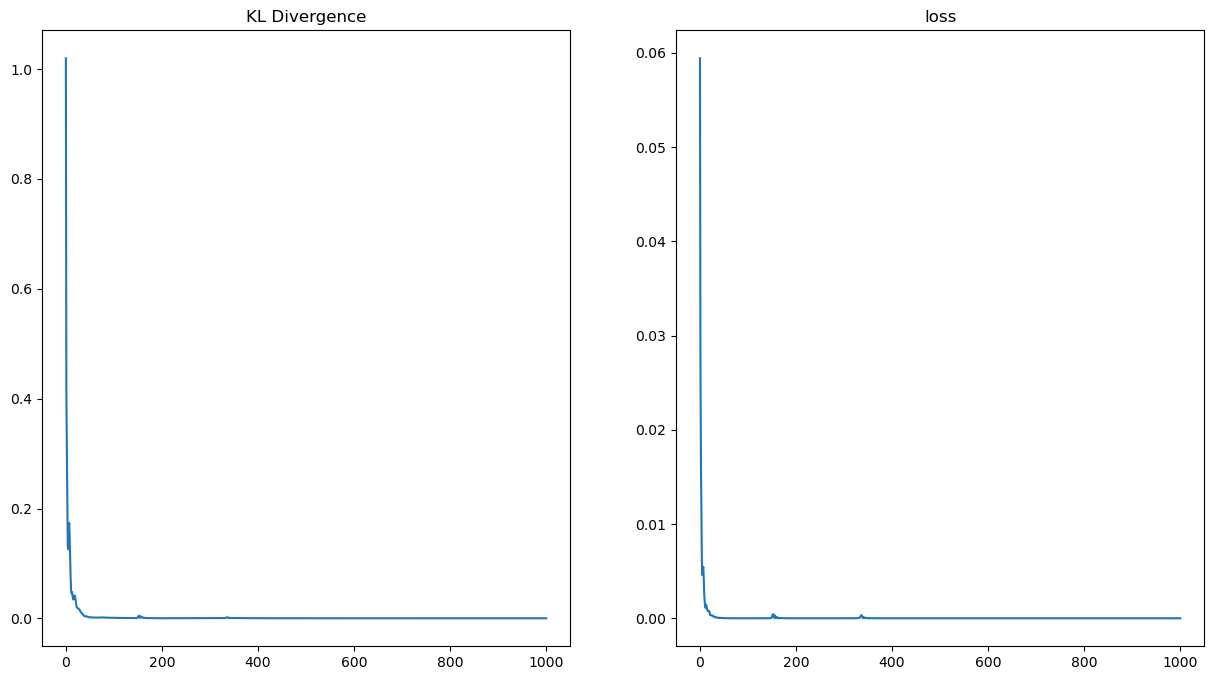

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

In [11]:
# optimal_params = weights[np.argmin(kl_values)]
# qcbm_probs = circuit(input_params=optimal_params)
# x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
# plt.bar(x_full,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
# plt.plot(x_full,target_distribution,color='blue',alpha=0.5,label='target_distribution')

Text(0, 0.5, 'Probability Distribution')

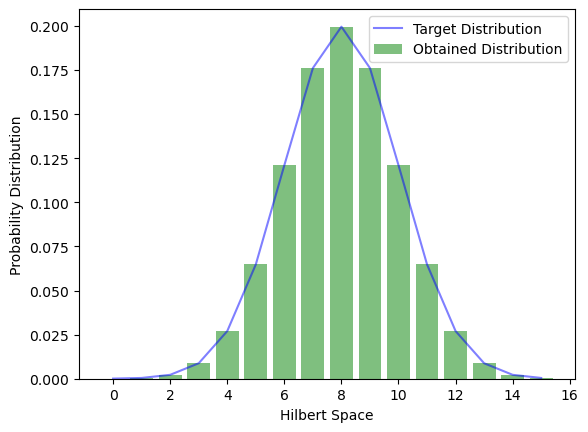

In [12]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
plt.bar(x_full,qcbm_probs,color='green',alpha=0.5,label='Obtained Distribution')
plt.plot(x_full,target_distribution,color='blue',alpha=0.5,label='Target Distribution')
plt.legend()
plt.xlabel('Hilbert Space')
plt.ylabel('Probability Distribution')

In [13]:
print(f"The minimum KL divergence obtained with ancillas and pre-training : 0.004266418516635895 in 5001 epochs")

The minimum KL divergence obtained with ancillas and pre-training : 0.004266418516635895 in 5001 epochs


In [14]:
print(f"The minimum KL divergence obtained with ancillas and no pre-training : 0.0036801521200686693 in 10001 epochs")

The minimum KL divergence obtained with ancillas and no pre-training : 0.0036801521200686693 in 10001 epochs


In [15]:
print(f"The minimum KL divergence obtained with ancillas, no pretraining and local entanglement in 0.004478096030652523 in 1001 epochs")

The minimum KL divergence obtained with ancillas, no pretraining and local entanglement in 0.004478096030652523 in 1001 epochs


In [16]:
print(f"The minimum KL divergence obtained with ancillas, no pretraining and local entanglement : {min(divs)} in 1001 epochs")

The minimum KL divergence obtained with ancillas, no pretraining and local entanglement : 0.000248816009843722 in 1001 epochs
